# Predicción del precio de alquiler de una casa vacacional en Madrid

## Estudio de los datos

In [ ]:
def getInputPath():
    return 'Inputs/'

In [ ]:
def getOutputPath():
    return 'Outputs/'

In [ ]:
import pandas as pd
import numpy as np
import json
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [ ]:
datos_airbnb_consolidados = pd.read_csv(getOutputPath() + "consolidados.csv")

In [ ]:
datos_airbnb_consolidados.info(verbose=True, null_counts = True)

In [ ]:
corr = datos_airbnb_consolidados.corr()
for column in corr.columns:
  for index in corr.index:
    if index != column and corr.loc[index, column] >= 0.95:
      print(index,' - ', column, ': ', corr.loc[index, column])

Voy a eliminar las columnas con correlación 1


In [ ]:
 datos_airbnb_consolidados = datos_airbnb_consolidados.drop(['host_total_listings_count', 'host_verification_sesame_offline', 'amenities_Wide_clearance_to_shower'], axis = 1)

Eliminaré también los precios por semana y mensuales y el Distrito

In [ ]:
datos_airbnb_consolidados = datos_airbnb_consolidados.drop(['weekly_price', 'monthly_price', 'Distrito'], axis = 1)

Además voy a eliminar las columnas de texto y de fecha

In [ ]:
for column in datos_airbnb_consolidados.columns:
  if column[0:2] == 'd_' or  column[0:2] == 's_':
    datos_airbnb_consolidados = datos_airbnb_consolidados.drop([column], axis=1)

In [ ]:
datos_airbnb_consolidados = datos_airbnb_consolidados.drop(['Barrio_Nombre', 'Distrito_Nombre', 'Unnamed: 0'], axis = 1)

In [ ]:
datos_airbnb_consolidados.info(verbose=True, null_counts=True)

In [ ]:
property_dummies = pd.get_dummies(datos_airbnb_consolidados.property_type, prefix='property_type', prefix_sep='_').astype('int64')
bed_dummies = pd.get_dummies(datos_airbnb_consolidados.bed_type, prefix='bed_type', prefix_sep='_').astype('int64')
room_dummies = pd.get_dummies(datos_airbnb_consolidados.room_type, prefix='room_type', prefix_sep='_').astype('int64')
datos_airbnb_consolidados = pd.concat([datos_airbnb_consolidados, property_dummies, bed_dummies, room_dummies], axis = 1)
datos_airbnb_consolidados = datos_airbnb_consolidados.drop(['property_type', 'bed_type', 'room_type'], axis=1)


In [ ]:
datos_airbnb_consolidados.host_response_time.value_counts()

In [ ]:
ctype = CategoricalDtype(categories=["within an hour", "within a few hours", "within a day", "a few days or more"],ordered=True)
datos_airbnb_consolidados.loc[:, 'host_response_time'] = datos_airbnb_consolidados.host_response_time.astype(ctype)

In [ ]:
datos_airbnb_consolidados.cancellation_policy.value_counts()

In [ ]:
ctype = CategoricalDtype(categories=["flexible", "moderate", "strict_14_with_grace_period", "super_strict_30", "super_strict_60"],ordered=True)
datos_airbnb_consolidados.loc[:, 'cancellation_policy'] = datos_airbnb_consolidados.cancellation_policy.astype(ctype)

In [ ]:

datos_airbnb_consolidados =pd.concat(
    [datos_airbnb_consolidados, datos_airbnb_consolidados.cancellation_policy.cat.codes, datos_airbnb_consolidados.host_response_time.cat.codes], axis = 1).drop(
    ['cancellation_policy', 'host_response_time'], axis = 1).rename(
    columns={1:'host_response_time',
            0:'cancellation_policy'})

In [ ]:
for column in datos_airbnb_consolidados.columns:
  datos_airbnb_consolidados.loc[datos_airbnb_consolidados[column].isna(), column] = datos_airbnb_consolidados[column].mean()

## Guardar datos

In [ ]:
datos_airbnb_consolidados.to_csv(path_or_buf=getOutputPath() + 'consolidados_ml.csv', sep=",")

## Preparar los datos

In [ ]:

datos_airbnb_consolidados = pd.read_csv(getInputPath() + "consolidados_ml.csv")
# Paso 1: Preparamos los datos
features = datos_airbnb_consolidados.columns.drop(['price'])
X = datos_airbnb_consolidados[features].values

y = datos_airbnb_consolidados['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)


print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)
print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Datos train:  (12631, 211)
Datos test:   (5414, 211)
Propocion train:74.025
Propocion test: 74.547


In [ ]:


# Paso 1.1: Preprocesar las variables
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)


In [ ]:

with open('resultados.json') as f:
    resultados = json.load(f)
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

## Regresión lineal

In [ ]:

param_grid = {}
grid_regresion = GridSearchCV(LinearRegression(),  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', param_grid =param_grid ,  cv = 5, n_jobs= -1, verbose = 1)
grid_regresion.fit(Xs_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

In [ ]:


print("best mean cross-validation score: {:.3f}".format(grid_regresion.best_score_))
print("best parameters: {}".format(grid_regresion.best_params_))

print("mse (train): {:.4f}".format(grid_regresion.score(Xs_train, y_train)))
print("mse (test): {:.4f}".format(grid_regresion.score(Xs_test, y_test)))

y_regression_predict_train = grid_regresion.predict(Xs_train)
y_regression_predict_test = grid_regresion.predict(Xs_test)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_regression_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_regression_predict_test)))

best mean cross-validation score: -6433263993997338965339799552.000
best parameters: {}
mse (train): -1802.5307
mse (test): -476306616186642423087104.0000
r2 (train): 0.5413
r2 (test): -123703708540964061184.0000


In [ ]:
resultados['regresion_lineal'] = {'mse_train': grid_regresion.score(Xs_train, y_train),
                                 'mse_test': grid_regresion.score(Xs_test, y_test),
                                 'r2_train': r2_score(y_train, y_regression_predict_train),
                                 'r2_test': r2_score(y_test, y_regression_predict_test)}
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20}}

### Rigge

In [ ]:

n_alphas = 20
alphas = np.logspace(-10, 10, n_alphas)

param_grid = {'alpha': alphas}
grid = GridSearchCV(Ridge(),  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', param_grid =param_grid ,  cv = 5, n_jobs= -1,return_train_score =True, verbose = 1)
grid.fit(Xs_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-10, 1.12884e-09, 1.27427e-08, 1.43845e-07, 1.62378e-06,
       1.83298e-05, 2.06914e-04, 2.33572e-03, 2.63665e-02, 2.97635e-01,
       3.35982e+00, 3.79269e+01, 4.28133e+02, 4.83293e+03, 5.45559e+04,
       6.15848e+05, 6.95193e+06, 7.84760e+07, 8.85867e+08, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

best mean cross-validation score: -1883.209
best parameters: {'alpha': 428.13323987193957}


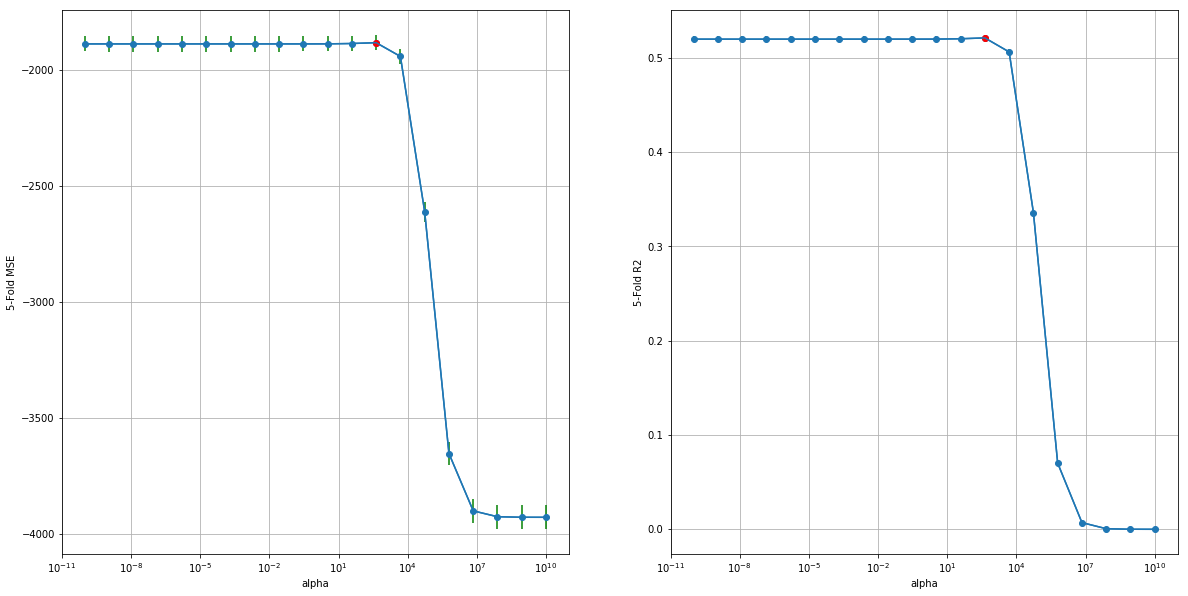

mse (train): -1805.6096
mse (test): -1786.4839
r2 (train): 0.5405
r2 (test): 0.5360


In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid.cv_results_['mean_test_neg_mean_squared_error']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid.cv_results_['std_train_neg_mean_squared_error'])
plt.semilogx(alphas,scores,'-o')
plt.semilogx(alphas[grid.best_index_],scores[grid.best_index_],'ro')
plt.errorbar(alphas, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('5-Fold MSE')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid.cv_results_['mean_test_r2']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid.cv_results_['std_train_r2'])
plt.semilogx(alphas,scores,'-o')
plt.semilogx(alphas[grid.best_index_],scores[grid.best_index_],'ro')
plt.errorbar(alphas, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('5-Fold R2')
plt.grid()
plt.show()


print("mse (train): {:.4f}".format(grid.score(Xs_train, y_train)))
print("mse (test): {:.4f}".format(grid.score(Xs_test, y_test)))

y_regression_predict_train = grid.predict(Xs_train)
y_regression_predict_test = grid.predict(Xs_test)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_regression_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_regression_predict_test)))

In [ ]:
resultados['rigde'] = {'mse_train': grid.score(Xs_train, y_train),
                       'mse_test': grid.score(Xs_test, y_test),
                       'r2_train': r2_score(y_train, y_regression_predict_train),
                       'r2_test': r2_score(y_test, y_regression_predict_test), 
                        'alpha': grid.best_params_['alpha']
                      }
resultados


{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957}}

### Ridge con R2

In [ ]:

n_alphas = 20
alphas = np.logspace(-10, 10, n_alphas)

param_grid = {'alpha': alphas}
grid_ridge_r2 = GridSearchCV(Ridge(),  scoring= ['neg_mean_squared_error', 'r2'], refit='r2', param_grid =param_grid ,  cv = 5, n_jobs= -1,return_train_score =True, verbose = 1)
grid_ridge_r2.fit(Xs_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-10, 1.12884e-09, 1.27427e-08, 1.43845e-07, 1.62378e-06,
       1.83298e-05, 2.06914e-04, 2.33572e-03, 2.63665e-02, 2.97635e-01,
       3.35982e+00, 3.79269e+01, 4.28133e+02, 4.83293e+03, 5.45559e+04,
       6.15848e+05, 6.95193e+06, 7.84760e+07, 8.85867e+08, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=1)

best mean cross-validation score: 0.521
best parameters: {'alpha': 428.13323987193957}


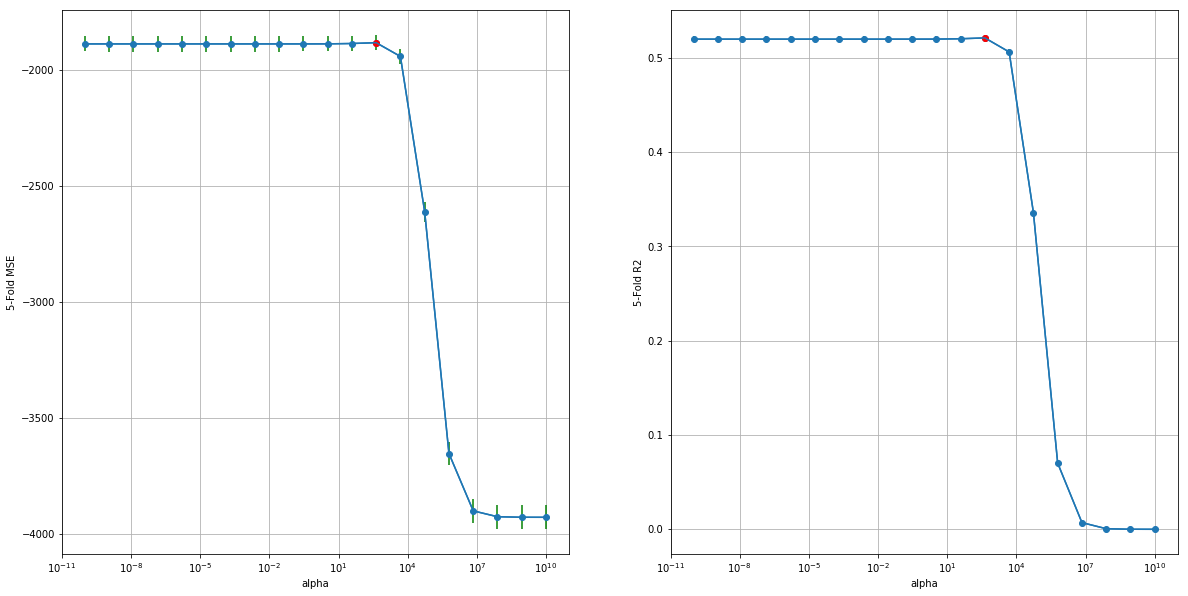

r2 (train): 0.5405
r2 (test): 0.5360
mse (train): 1805.6096
mse (test): 1786.4839


In [ ]:

print("best mean cross-validation score: {:.3f}".format(grid_ridge_r2.best_score_))
print("best parameters: {}".format(grid_ridge_r2.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid_ridge_r2.cv_results_['mean_test_neg_mean_squared_error']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_ridge_r2.cv_results_['std_train_neg_mean_squared_error'])
plt.semilogx(alphas,scores,'-o')
plt.semilogx(alphas[grid_ridge_r2.best_index_],scores[grid_ridge_r2.best_index_],'ro')
plt.errorbar(alphas, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('5-Fold MSE')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid_ridge_r2.cv_results_['mean_test_r2']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_ridge_r2.cv_results_['std_train_r2'])
plt.semilogx(alphas,scores,'-o')
plt.semilogx(alphas[grid_ridge_r2.best_index_],scores[grid_ridge_r2.best_index_],'ro')
plt.errorbar(alphas, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('5-Fold R2')
plt.grid()
plt.show()

print("r2 (train): {:.4f}".format(grid_ridge_r2.score(Xs_train, y_train)))
print("r2 (test): {:.4f}".format(grid_ridge_r2.score(Xs_test, y_test)))


y_predict_train = grid_ridge_r2.predict(Xs_train)
y_predict_test = grid_ridge_r2.predict(Xs_test)

print("mse (train): {:.4f}".format(mean_squared_error(y_train, y_predict_train)))
print("mse (test): {:.4f}".format(mean_squared_error(y_test, y_predict_test)))

In [ ]:
resultados['rigde_r2'] = {'r2_train': grid_ridge_r2.score(Xs_train, y_train),
                       'r2_test': grid_ridge_r2.score(Xs_test, y_test),
                       'mse_train': mean_squared_error(y_train, y_predict_train),
                       'mse_test': mean_squared_error(y_test, y_predict_test), 
                        'alpha': grid_ridge_r2.best_params_['alpha']
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957}}

### Lasso

In [ ]:

n_alphas = 10
alphas = np.logspace(-10, 10, n_alphas)
param_grid = {'alpha': alphas}
grid_lasso = GridSearchCV(Lasso(),  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', param_grid =param_grid ,  cv = 10, n_jobs= -1, verbose = 3)
grid_lasso.fit(Xs_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-10, 1.66810e-08, 2.78256e-06, 4.64159e-04, 7.74264e-02,
       1.29155e+01, 2.15443e+03, 3.59381e+05, 5.99484e+07, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=3)

best mean cross-validation score: -1879.619
best parameters: {'alpha': 0.07742636826811278}


C:\Users\Carolina\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Carolina\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


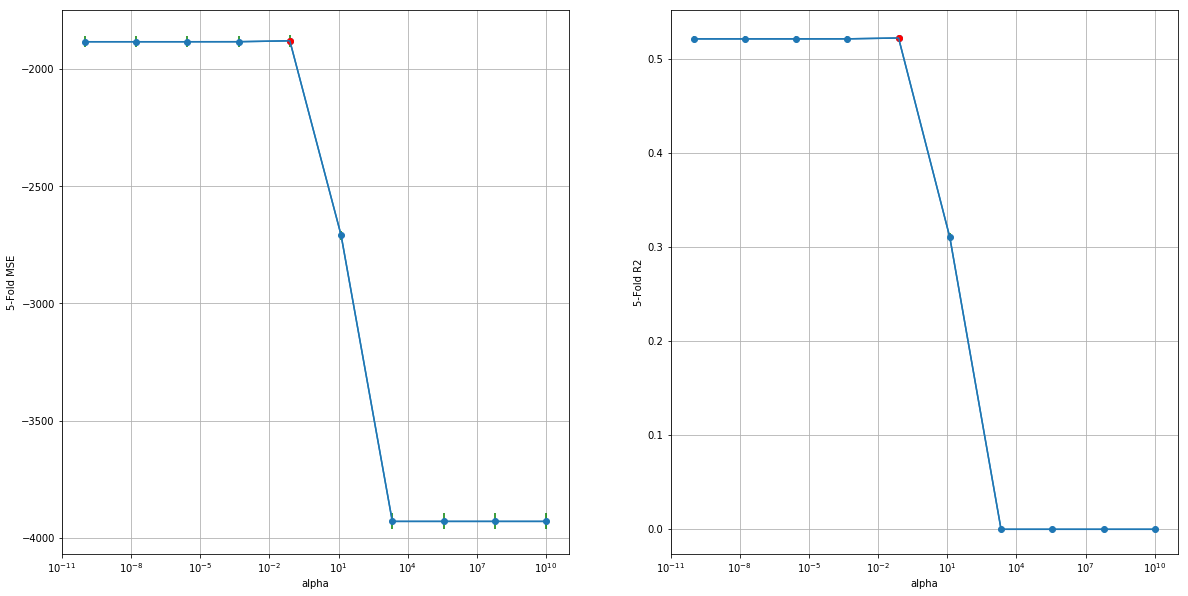

r2 (train): -1805.5321
r2 (test): -1777.1562
mse (train): 0.5405
mse (test): 0.5384


In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid_lasso.best_score_))
print("best parameters: {}".format(grid_lasso.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid_lasso.cv_results_['mean_test_neg_mean_squared_error']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_lasso.cv_results_['std_train_neg_mean_squared_error'])
plt.semilogx(alphas,scores,'-o')
plt.semilogx(alphas[grid_lasso.best_index_],scores[grid_lasso.best_index_],'ro')
plt.errorbar(alphas, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('5-Fold MSE')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid_lasso.cv_results_['mean_test_r2']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_lasso.cv_results_['std_train_r2'])
plt.semilogx(alphas,scores,'-o')
plt.semilogx(alphas[grid_lasso.best_index_],scores[grid_lasso.best_index_],'ro')
plt.errorbar(alphas, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('5-Fold R2')
plt.grid()
plt.show()

print("r2 (train): {:.4f}".format(grid_lasso.score(Xs_train, y_train)))
print("r2 (test): {:.4f}".format(grid_lasso.score(Xs_test, y_test)))


y_predict_train = grid_lasso.predict(Xs_train)
y_predict_test = grid_lasso.predict(Xs_test)

print("mse (train): {:.4f}".format(r2_score(y_train, y_predict_train)))
print("mse (test): {:.4f}".format(r2_score(y_test, y_predict_test)))

In [ ]:
resultados['lasso'] = {'mse_train': grid_lasso.score(Xs_train, y_train),
                       'mse_test': grid_lasso.score(Xs_test, y_test),
                       'r2_train': r2_score(y_train, y_predict_train),
                       'r2_test': r2_score(y_test, y_predict_test), 
                        'alpha': grid_lasso.best_params_['alpha']
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

In [ ]:

with open(getOutputPath() + 'resultados.json', 'w') as fp:
    json.dump(resultados, fp, indent=4)

## Selección de variables

### Selección de variables: f_regression, mutual_info

In [ ]:

# do calculations
f_test_, a = f_regression(Xs_train, y_train,center=False)
f_test = f_test_ / np.nanmax(f_test_)

mi = mutual_info_regression(Xs_train, y_train)
mi /= np.max(mi)


C:\Users\Carolina\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Carolina\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Carolina\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Carolina\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [ ]:
f_test = f_test_ / np.nanmax(f_test_)

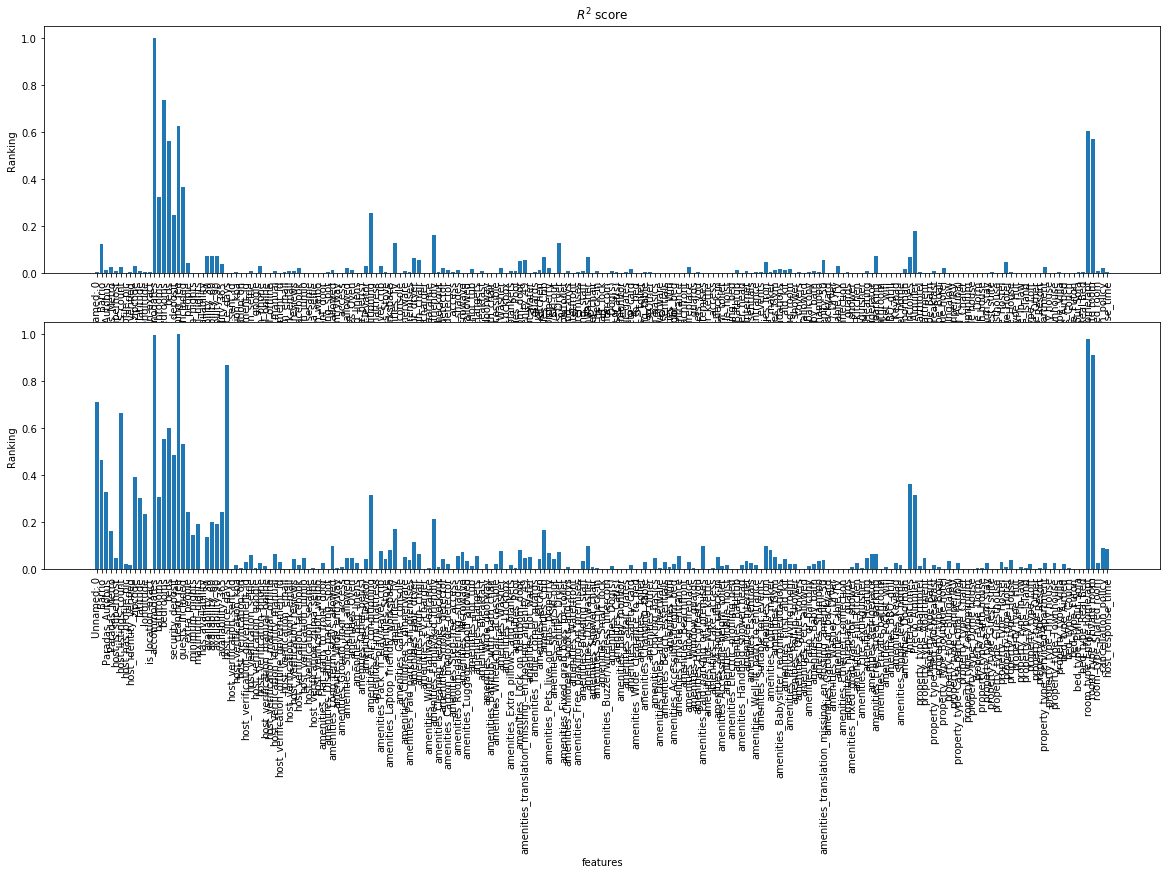

In [ ]:

# do some plotting
plt.figure(figsize=(20, 10))

plt.subplot(2,1,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(Xs_train.shape[1]),features, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$R^2$ score')

plt.subplot(2,1,2)
plt.bar(range(Xs_train.shape[1]),mi, align="center")
plt.xticks(range(Xs_train.shape[1]),features, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

In [ ]:
delete_coef_indices_f_reg = [i for i, fi in enumerate(f_test) if fi == 0.0 or np.isnan(fi)]
delete_coef_indices_mutual_info = [i for i, mii in enumerate(mi) if mii == 0.0]

In [ ]:
delete_features_f_reg = [f for (i, f) in enumerate(features.tolist()) if i in delete_coef_indices_f_reg]
delete_features_mutual_info = [f for (i, f) in enumerate(features.tolist()) if i in delete_coef_indices_mutual_info]


In [ ]:
with open(getOutputPath() + 'delete_features_f_reg.json', 'w') as fp:
    json.dump(delete_features_f_reg, fp, indent=4)
with open(getOutputPath() + 'delete_features_mutual_info.json', 'w') as fp:
    json.dump(delete_features_mutual_info, fp, indent=4)

### Modelo reducido: mutual_info

In [ ]:
with open('delete_features_mutual_info.json') as f:
    delete_features = json.load(f)
delete_coef_indices_mutual_info = [features.tolist().index(f) for f in delete_features]


In [ ]:
Xs_train_red_mi = np.delete(Xs_train, delete_coef_indices_mutual_info, 1)
Xs_test_red_mi =  np.delete(Xs_test, delete_coef_indices_mutual_info, 1)

### Regresión simplificada: mutual_info

In [ ]:
Xs_train_red_mi

array([[ 0.91235378,  1.11746142, -0.33131594, ..., -0.11218814,
        -1.26309572, -1.38697201],
       [-0.99409096, -0.72113177, -0.39666544, ..., -0.11218814,
         1.12704091, -0.22709095],
       [-1.18975139, -0.72113177, -0.39666544, ..., -0.11218814,
        -1.26309572,  0.9327901 ],
       ...,
       [-0.73410382, -0.68027414, -1.05016049, ..., -0.11218814,
         1.12704091, -0.22709095],
       [ 0.60220711,  0.52502584, -0.13526742, ..., -0.11218814,
         1.12704091,  0.9327901 ],
       [-1.68311432, -0.49641483, -0.78876247, ..., -0.11218814,
         1.12704091, -0.22709095]])

In [ ]:

param_grid = {}
grid_regresion_red_mi = GridSearchCV(LinearRegression(),  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', param_grid =param_grid ,  cv = 5, n_jobs= 5, verbose = 1)
grid_regresion_red_mi.fit(Xs_train_red_mi, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=5, param_grid={},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

In [ ]:


print("best mean cross-validation score: {:.3f}".format(grid_regresion_red_mi.best_score_))
print("best parameters: {}".format(grid_regresion_red_mi.best_params_))

print("mse (train): {:.4f}".format(grid_regresion_red_mi.score(Xs_train_red_mi, y_train)))
print("mse (test): {:.4f}".format(grid_regresion_red_mi.score(Xs_test_red_mi, y_test)))

y_regression_predict_train = grid_regresion_red_mi.predict(Xs_train_red_mi)
y_regression_predict_test = grid_regresion_red_mi.predict(Xs_test_red_mi)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_regression_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_regression_predict_test)))

best mean cross-validation score: -69713323413968622753350156288.000
best parameters: {}
mse (train): -1852.9824
mse (test): -1841.9868
r2 (train): 0.5285
r2 (test): 0.5216


### Selección de variables con Lasso

In [ ]:
alpha_optimo = grid_lasso.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(Xs_train,y_train)

ytrainLasso = lasso.predict(Xs_train)
ytestLasso  = lasso.predict(Xs_test)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

r2TrainModelLasso = r2_score(y_train,ytrainLasso)
r2TestModelLasso = r2_score(y_test,ytestLasso)

print('R2 Modelo Lasso (train): %0.3g' % r2TrainModelLasso)
print('R2 Modelo Lasso (test) : %0.3g' % r2TestModelLasso)

w = lasso.coef_
features_coef = []
for f,wi in zip(features,w):
    print(f,wi)
    features_coef.append((f,wi))


MSE Modelo Lasso (train): 1.81e+03
MSE Modelo Lasso (test) : 1.78e+03
R2 Modelo Lasso (train): 0.541
R2 Modelo Lasso (test) : 0.538
Unnamed: 0 1.351133394722844
Barrio -1.217381693213756
Paradas_Autobus -0.9818040325941951
Paradas_Metro -1.4342673076756995
host_is_superhost 0.0
host_listings_count -6.892464454726688
host_has_profile_pic -0.0021323433599826605
host_identity_verified -0.8362116606853638
zipcode -0.9262760472376879
latitude 0.4539200798740328
longitude -0.031127006911148124
is_location_exact -0.6334029069981247
accommodates 8.8877097550776
bathrooms 6.395056545927386
bedrooms 10.707274770002794
beds -0.9738426122010041
security_deposit 4.4103880886385
cleaning_fee 11.884583441539712
guests_included 2.9149692381338124
extra_people -0.7494713414286424
minimum_nights -1.3760450211797952
maximum_nights 0.0
has_availability 0.0
availability_30 6.2710708040557925
availability_60 3.0674521667809764
availability_90 -1.1236640905696516
availability_365 0.7511766811255802
host_sinc

In [ ]:
features_coef.sort(key=lambda x: x[1])

## Crear modelo simplificado

In [ ]:
delete_coef_indices = [i for i, wi in enumerate(w) if wi == 0]

In [ ]:
delete_features = [f for (i, f) in enumerate(features.tolist()) if i in delete_coef_indices]
non_delete_features = [f for (i, f) in enumerate(features.tolist()) if i not in delete_coef_indices]
with open(getOutputPath() + 'delete_features.json', 'w') as fp:
    json.dump(delete_features, fp, indent=4)
with open(getOutputPath() + 'non_delete_features.json', 'w') as fp:
    json.dump(non_delete_features, fp, indent=4)

In [ ]:
with open('delete_features.json') as f:
    delete_features = json.load(f)
delete_coef_indices = [features.tolist().index(f) for f in delete_features]


## Regresión simplificada

In [ ]:

param_grid = {}
grid_regresion_red = GridSearchCV(LinearRegression(),  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', param_grid =param_grid ,  cv = 5, n_jobs= -1, verbose = 1)
grid_regresion_red.fit(Xs_train_red, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

In [ ]:
from sklearn.metrics import r2_score

print("best mean cross-validation score: {:.3f}".format(grid_regresion_red.best_score_))
print("best parameters: {}".format(grid_regresion_red.best_params_))

print("mse (train): {:.4f}".format(grid_regresion_red.score(Xs_train_red, y_train)))
print("mse (test): {:.4f}".format(grid_regresion_red.score(Xs_test_red, y_test)))

y_regression_predict_train = grid_regresion_red.predict(Xs_train_red)
y_regression_predict_test = grid_regresion_red.predict(Xs_test_red)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_regression_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_regression_predict_test)))

best mean cross-validation score: -1916.264
best parameters: {}
mse (train): -1803.9473
mse (test): -1789.7565
r2 (train): 0.5409
r2 (test): 0.5352


In [ ]:
resultados['regresion_lineal_red'] = {'mse_train': grid_regresion_red.score(Xs_train_red, y_train),
                                 'mse_test': grid_regresion_red.score(Xs_test_red, y_test),
                                 'r2_train': r2_score(y_train, y_regression_predict_train),
                                 'r2_test': r2_score(y_test, y_regression_predict_test)}
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025}}

## Árboles de regresión

In [ ]:


max_depth = np.arange(2, 10, 1)
param_grid = {'max_depth': max_depth}
grid_tree = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', cv = 10, verbose = 1,return_train_score =True)
grid_tree.fit(Xs_train_red, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   12.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

best mean cross-validation score: -1972.059
best parameters: {'max_depth': 6}


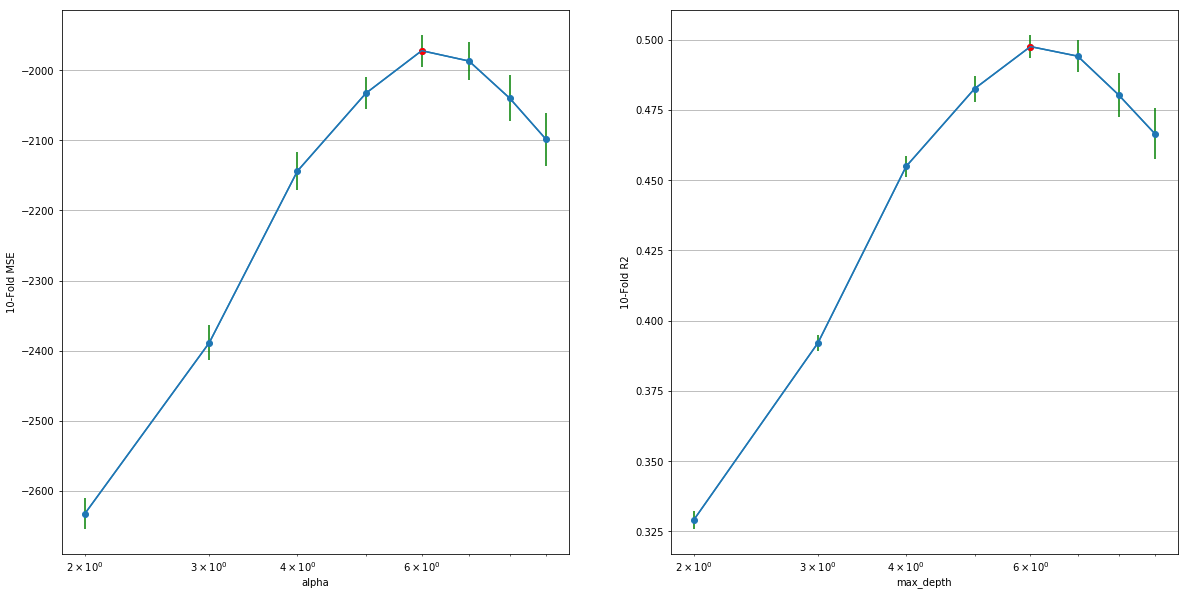

mse (train): -1679.7234
mse (test): -1804.0145
r2 (train): 0.5725
r2 (test): 0.5315


In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid_tree.best_score_))
print("best parameters: {}".format(grid_tree.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid_tree.cv_results_['mean_test_neg_mean_squared_error']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_tree.cv_results_['std_train_neg_mean_squared_error'])
plt.semilogx(max_depth,scores,'-o')
plt.semilogx(max_depth[grid_tree.best_index_],scores[grid_tree.best_index_],'ro')
plt.errorbar(max_depth, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('alpha')
plt.ylabel('10-Fold MSE')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid_tree.cv_results_['mean_test_r2']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_tree.cv_results_['std_train_r2'])
plt.semilogx(max_depth,scores,'-o')
plt.semilogx(max_depth[grid_tree.best_index_],scores[grid_tree.best_index_],'ro')
plt.errorbar(max_depth, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('max_depth')
plt.ylabel('10-Fold R2')
plt.grid()
plt.show()

print("mse (train): {:.4f}".format(grid_tree.score(Xs_train_red, y_train)))
print("mse (test): {:.4f}".format(grid_tree.score(Xs_test_red, y_test)))


y_predict_train = grid_tree.predict(Xs_train_red)
y_predict_test = grid_tree.predict(Xs_test_red)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_predict_test)))

In [ ]:
resultados['tree'] = {'mse_train': grid_tree.score(Xs_train_red, y_train),
                       'mse_test': grid_tree.score(Xs_test_red, y_test),
                       'r2_train': r2_score(y_train, y_predict_train),
                       'r2_test': r2_score(y_test, y_predict_test), 
                        'max_depth': float(grid_tree.best_params_['max_depth'])
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

## SVM

In [ ]:

with open(getOutputPath() + 'resultados.json', 'w') as fp:
    json.dump(resultados, fp, indent=4)

### Primera aproximación: Parámetros C y gamma

In [ ]:
vectorC = np.logspace(-2, 2, 3)
vectorG = np.logspace(-5, 1, 5)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid_SVM = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid,  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', cv = 3, verbose = 2, n_jobs=5,return_train_score =True)
grid_SVM.fit(Xs_train_red, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed: 23.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'C': array([1.e-02, 1.e+00, 1.e+02]), 'gamma': array([1.00000e-05, 3.16228e-04, 1.00000e-02, 3.16228e-01, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=2)

In [ ]:
y_predict_train = grid_SVM.predict(Xs_train_red)
y_predict_test = grid_SVM.predict(Xs_test_red)

resultados['svm'] = {'mse_train': grid_SVM.score(Xs_train_red, y_train),
                      'mse_test': grid_SVM.score(Xs_test_red, y_test),
                      'r2_train': r2_score(y_train, y_predict_train),
                      'r2_test': r2_score(y_test, y_predict_test), 
                      'C': float(grid_SVM.best_params_['C']),
                      'gamma': float(grid_SVM.best_params_['gamma'])
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

best mean cross-validation score: -1813.988
best parameters: {'C': 100.0, 'gamma': 0.01}


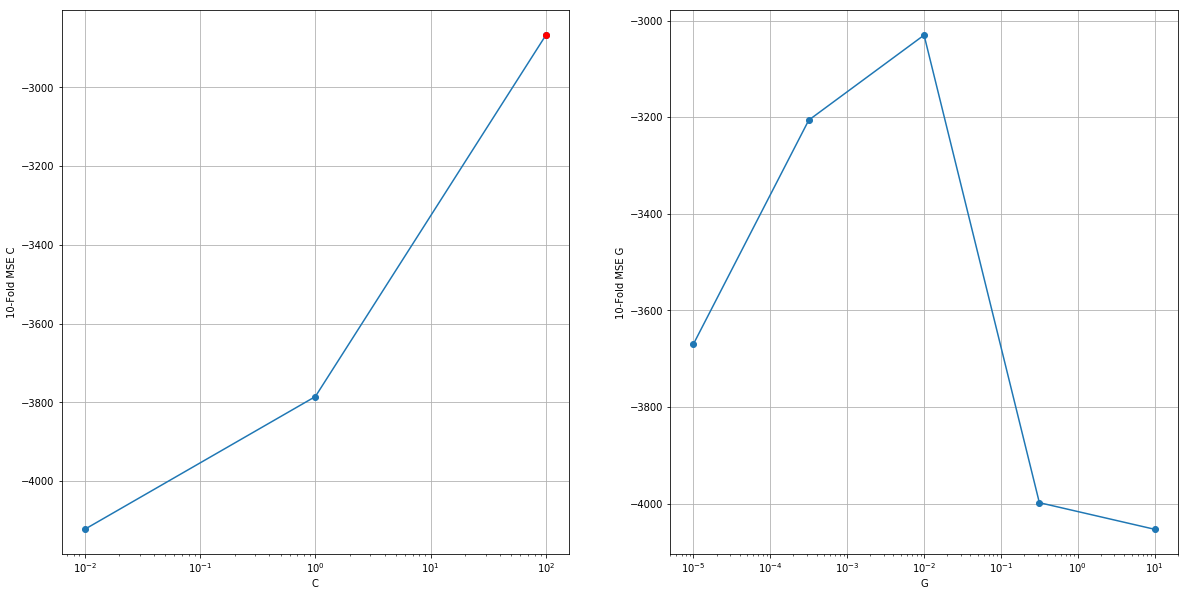

mse (train): -836.1274
mse (test): -1502.9799
r2 (train): 0.7872
r2 (test): 0.6097


In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid_SVM.best_score_))
print("best parameters: {}".format(grid_SVM.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid_SVM.cv_results_['mean_test_neg_mean_squared_error']).reshape(len(vectorC), len(vectorG))
stdvalues = np.array(grid_SVM.cv_results_['std_train_neg_mean_squared_error']).reshape(len(vectorC), len(vectorG))
plt.semilogx(vectorC,scores.mean(axis=1),'-o')
plt.semilogx(vectorC[int(grid_SVM.best_index_/5)],scores.mean(axis=1)[int(grid_SVM.best_index_/5)],'ro')
#plt.errorbar(vectorC, scores.mean(axis=1), yerr=stdvalues, ecolor='g')
plt.xlabel('C')
plt.ylabel('10-Fold MSE C')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid_SVM.cv_results_['mean_test_neg_mean_squared_error']).reshape(len(vectorC), len(vectorG))
stdvalues = np.array(grid_SVM.cv_results_['std_train_neg_mean_squared_error']).reshape(len(vectorC), len(vectorG))
plt.semilogx(vectorG,scores.mean(axis=0),'-o')
#plt.semilogx(vectorG[int(grid_SVM.best_index_/5)],scores.mean(axis=1)[int(grid_SVM.best_index_/5)],'ro')
#plt.errorbar(vectorC, scores.mean(axis=1), yerr=stdvalues, ecolor='g')
plt.xlabel('G')
plt.ylabel('10-Fold MSE G')
plt.grid()
plt.show()

print("mse (train): {:.4f}".format(grid_SVM.score(Xs_train_red, y_train)))
print("mse (test): {:.4f}".format(grid_SVM.score(Xs_test_red, y_test)))


y_predict_train = grid_SVM.predict(Xs_train_red)
y_predict_test = grid_SVM.predict(Xs_test_red)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_predict_test)))

### Fijando gamma

In [ ]:

vectorC = np.logspace(1, 5, 10)


param_grid = {'C': vectorC, 'gamma':[0.01]}
grid_SVM_2 = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid,  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', cv = 3, verbose = 2, n_jobs=5,return_train_score =True)
grid_SVM_2.fit(Xs_train_red, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 22.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'C': array([1.00000e+01, 2.78256e+01, 7.74264e+01, 2.15443e+02, 5.99484e+02,
       1.66810e+03, 4.64159e+03, 1.29155e+04, 3.59381e+04, 1.00000e+05]), 'gamma': [0.01]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=2)

In [ ]:
y_predict_train = grid_SVM_2.predict(Xs_train_red)
y_predict_test = grid_SVM_2.predict(Xs_test_red)

resultados['svm_2'] = {'mse_train': grid_SVM_2.score(Xs_train_red, y_train),
                      'mse_test': grid_SVM_2.score(Xs_test_red, y_test),
                      'r2_train': r2_score(y_train, y_predict_train),
                      'r2_test': r2_score(y_test, y_predict_test), 
                      'C': float(grid_SVM_2.best_params_['C']),
                      'gamma': 0.01
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

In [ ]:

with open(getOutputPath() + 'resultados.json', 'w') as fp:
    json.dump(resultados, fp, indent=4)

best mean cross-validation score: -1687.587
best parameters: {'C': 599.4842503189409, 'gamma': 0.01}


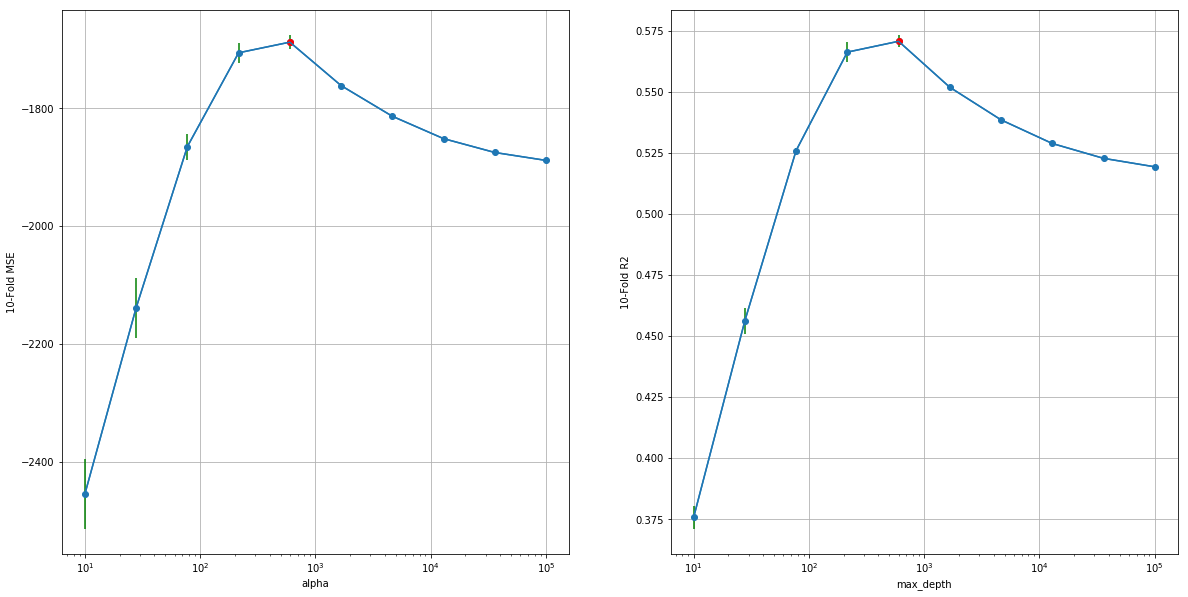

In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid_SVM_2.best_score_))
print("best parameters: {}".format(grid_SVM_2.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid_SVM_2.cv_results_['mean_test_neg_mean_squared_error']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_SVM_2.cv_results_['std_train_neg_mean_squared_error'])
plt.semilogx(vectorC,scores,'-o')
plt.semilogx(vectorC[grid_SVM_2.best_index_],scores[grid_SVM_2.best_index_],'ro')
plt.errorbar(vectorC, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('C')
plt.ylabel('10-Fold MSE')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid_SVM_2.cv_results_['mean_test_r2']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_SVM_2.cv_results_['std_train_r2'])
plt.semilogx(vectorC,scores,'-o')
plt.semilogx(vectorC[grid_SVM_2.best_index_],scores[grid_SVM_2.best_index_],'ro')
plt.errorbar(vectorC, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('C')
plt.ylabel('10-Fold R2')
plt.grid()
plt.show()

#print("mse (train): {:.4f}".format(grid_tree.score(Xs_train_red, y_train)))
#print("mse (test): {:.4f}".format(grid_tree.score(Xs_test_red, y_test)))


#y_predict_train = grid_tree.predict(Xs_train_red)
#y_predict_test = grid_tree.predict(Xs_test_red)

#print("r2 (train): {:.4f}".format(r2_score(y_train, y_predict_train)))
#print("r2 (test): {:.4f}".format(r2_score(y_test, y_predict_test)))

### Búqueda exhaustiva de parámetros óptimos: C, gamma y kernel

In [ ]:
vectorC = np.arange(100, 300, 10)
vectorG = np.logspace(-5, 1, 10)
kernel = ['rbf', 'poly', 'sigmoid']
param_grid = {'C': vectorC, 'gamma':vectorG, 'kernel': kernel}
grid_SVM_3 = GridSearchCV(SVR(), param_grid=param_grid,  scoring= 'neg_mean_squared_error', cv = 3, verbose = 2, n_jobs=5,return_train_score =True)
grid_SVM_3.fit(Xs_train_red, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 10.0min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 70.3min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 714.9min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 866.7min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 1049.7min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 1273.5min
[Parallel(n_jobs=5)]: Done 1800 out of 1800 | elapsed: 1455.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'C': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290]), 'gamma': array([1.00000e-05, 4.64159e-05, 2.15443e-04, 1.00000e-03, 4.64159e-03,
       2.15443e-02, 1.00000e-01, 4.64159e-01, 2.15443e+00, 1.00000e+01]), 'kernel': ['rbf', 'poly', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [ ]:
y_predict_train = grid_SVM_3.predict(Xs_train_red)
y_predict_test = grid_SVM_3.predict(Xs_test_red)

resultados['svm_3'] = {'mse_train': grid_SVM_3.score(Xs_train_red, y_train),
                      'mse_test': grid_SVM_3.score(Xs_test_red, y_test),
                      'r2_train': r2_score(y_train, y_predict_train),
                      'r2_test': r2_score(y_test, y_predict_test), 
                      'C': float(grid_SVM_3.best_params_['C']),
                      'gamma': 0.01
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

In [ ]:

with open(getOutputPath() + 'resultados.json', 'w') as fp:
    json.dump(resultados, fp, indent=4)

In [ ]:
grid_SVM_3.best_params_

{'C': 290, 'gamma': 0.004641588833612777, 'kernel': 'rbf'}

In [ ]:
vectorC, vectorG, kernel

(array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
        230, 240, 250, 260, 270, 280, 290]),
 array([1.00000000e-05, 4.64158883e-05, 2.15443469e-04, 1.00000000e-03,
        4.64158883e-03, 2.15443469e-02, 1.00000000e-01, 4.64158883e-01,
        2.15443469e+00, 1.00000000e+01]),
 ['rbf', 'poly', 'sigmoid'])

best mean cross-validation score: -1657.785
best parameters: {'C': 290, 'gamma': 0.004641588833612777, 'kernel': 'rbf'}


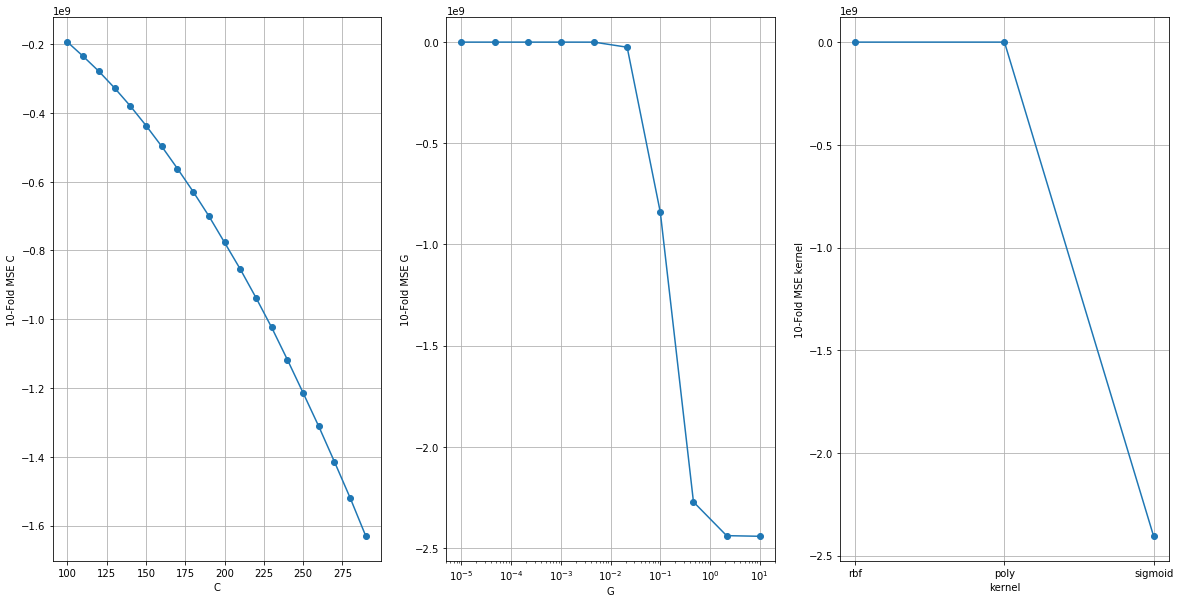

In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid_SVM_3.best_score_))
print("best parameters: {}".format(grid_SVM_3.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,3,1)
scores = np.array(grid_SVM_3.cv_results_['mean_test_score']).reshape(len(vectorC), len(vectorG), len(kernel))
stdvalues = np.array(grid_SVM_3.cv_results_['std_test_score']).reshape(len(vectorC), len(vectorG), len(kernel))
plt.plot(vectorC,scores.mean(axis=(1,2)),'-o')
#plt.semilogx(vectorC[int(grid_SVM.best_index_/5)],scores.mean(axis=1)[int(grid_SVM.best_index_/5)],'ro')
#plt.errorbar(vectorC, scores.mean(axis=1), yerr=stdvalues, ecolor='g')
plt.xlabel('C')
plt.ylabel('10-Fold MSE C')
plt.grid()


plt.subplot(1,3,2)
plt.semilogx(vectorG,scores.mean(axis=(0,2)),'-o')
#plt.semilogx(vectorG[int(grid_SVM.best_index_/5)],scores.mean(axis=1)[int(grid_SVM.best_index_/5)],'ro')
#plt.errorbar(vectorC, scores.mean(axis=1), yerr=stdvalues, ecolor='g')
plt.xlabel('G')
plt.ylabel('10-Fold MSE G')
plt.grid()


plt.subplot(1,3,3)
plt.plot(kernel,scores.mean(axis=(0,1)),'-o')
#plt.semilogx(vectorG[int(grid_SVM.best_index_/5)],scores.mean(axis=1)[int(grid_SVM.best_index_/5)],'ro')
#plt.errorbar(vectorC, scores.mean(axis=1), yerr=stdvalues, ecolor='g')
plt.xlabel('kernel')
plt.ylabel('10-Fold MSE kernel')
plt.grid()

plt.show()


### SVR óptimo

In [ ]:
svr = SVR(C=grid_SVM_3.best_params_['C'], gamma=grid_SVM_3.best_params_['gamma'], kernel=grid_SVM_3.best_params_['kernel'],verbose=2).fit(Xs_train_red, y_train)
y_predict_train = svr.predict(Xs_train_red)
y_predict_test = svr.predict(Xs_test_red)

mse_score_train = mean_squared_error(y_true=y_train, y_pred=y_predict_train)
r2_score_train = r2_score(y_true=y_train, y_pred=y_predict_train)

mse_score_test = mean_squared_error(y_true=y_test, y_pred=y_predict_test)
r2_score_test = r2_score(y_true=y_test, y_pred=y_predict_test)

resultados['svm_final'] = {'mse_train': mse_score_train,
                      'mse_test': mse_score_test,
                      'r2_train': r2_score_train,
                      'r2_test': r2_score_test, 
                      'C': float(grid_SVM_3.best_params_['C']),
                      'gamma': float(grid_SVM_3.best_params_['gamma']),
                       'kernel':grid_SVM_3.best_params_['kernel']
                      }
resultados

[LibSVM]

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

## Linear SVR

In [ ]:
vectorC = np.logspace(-2, 4 , 10)
param_grid = {'C': vectorC}
grid_LSVM = GridSearchCV(LinearSVR(), param_grid=param_grid,  scoring= ['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', cv = 3, verbose = 2, return_train_score =True)
grid_LSVM.fit(Xs_train_red, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.046415888336127774 ..........................................
[CV] ........................... C=0.046415888336127774, total=   0.0s
[CV] C=0.046415888336127774 ..........................................
[CV] ........................... C=0.046415888336127774, total=   0.1s
[CV] C=0.046415888336127774 ..........................................
[CV] ........................... C=0.046415888336127774, total=   0.1s
[CV] C=0.21544346900318834 ...........................................
[CV] ............................ C=0.21544346900318834, total=   0.2s
[CV] C=0.21544346900318834 ...........................................
[CV] ............................ C=0.21544346900318834, total=   0.3s
[CV] C=0.21544346900318834 ...........................................
[CV] ............................ C=0.21544346900318834, total=   0.3s
[CV] C=1.0 ...........................................................
[CV] 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=2)

best mean cross-validation score: -2156.898
best parameters: {'C': 4.6415888336127775}


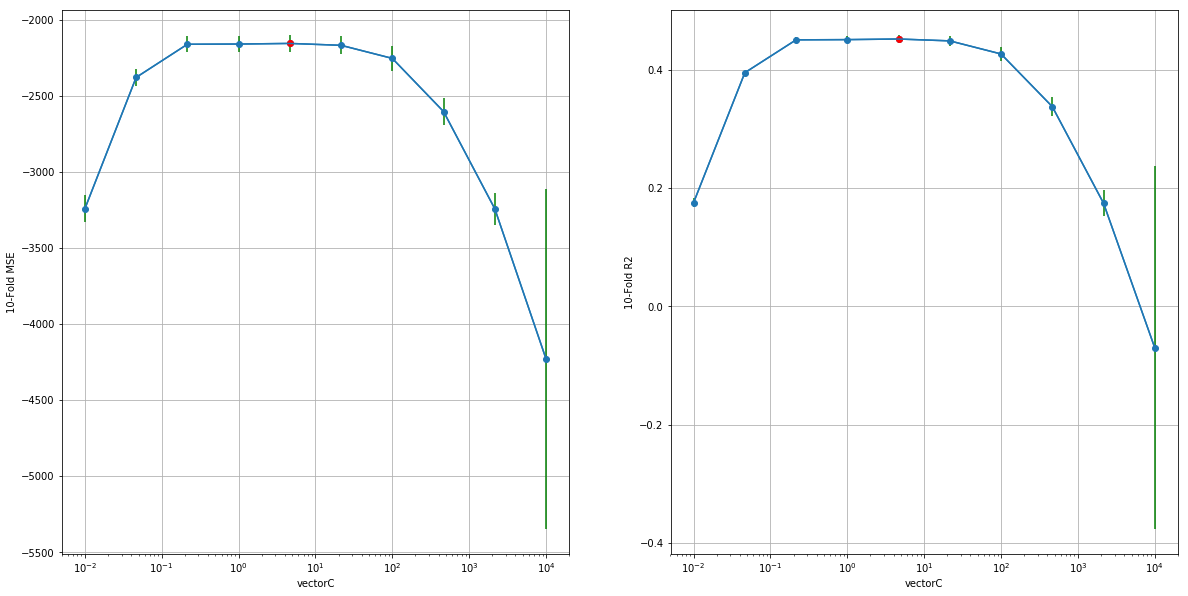

mse (train): -2073.9197
mse (test): -1995.5478
r2 (train): 0.4722
r2 (test): 0.4817


In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid_LSVM.best_score_))
print("best parameters: {}".format(grid_LSVM.best_params_))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
scores = np.array(grid_LSVM.cv_results_['mean_test_neg_mean_squared_error']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_LSVM.cv_results_['std_train_neg_mean_squared_error'])
plt.semilogx(vectorC,scores,'-o')
plt.semilogx(vectorC[grid_LSVM.best_index_],scores[grid_LSVM.best_index_],'ro')
plt.errorbar(vectorC, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('vectorC')
plt.ylabel('10-Fold MSE')
plt.grid()


plt.subplot(1,2,2)
scores = np.array(grid_LSVM.cv_results_['mean_test_r2']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_LSVM.cv_results_['std_train_r2'])
plt.semilogx(vectorC,scores,'-o')
plt.semilogx(vectorC[grid_LSVM.best_index_],scores[grid_LSVM.best_index_],'ro')
plt.errorbar(vectorC, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('vectorC')
plt.ylabel('10-Fold R2')
plt.grid()
plt.show()

print("mse (train): {:.4f}".format(grid_LSVM.score(Xs_train_red, y_train)))
print("mse (test): {:.4f}".format(grid_LSVM.score(Xs_test_red, y_test)))


y_predict_train = grid_LSVM.predict(Xs_train_red)
y_predict_test = grid_LSVM.predict(Xs_test_red)

print("r2 (train): {:.4f}".format(r2_score(y_train, y_predict_train)))
print("r2 (test): {:.4f}".format(r2_score(y_test, y_predict_test)))

In [ ]:
y_predict_train = grid_LSVM.predict(Xs_train_red)
y_predict_test = grid_LSVM.predict(Xs_test_red)

resultados['lsvm'] = {'mse_train': grid_LSVM.score(Xs_train_red, y_train),
                      'mse_test': grid_LSVM.score(Xs_test_red, y_test),
                      'r2_train': r2_score(y_train, y_predict_train),
                      'r2_test': r2_score(y_test, y_predict_test), 
                      'C': float(grid_LSVM.best_params_['C'])
                      }
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

# CONCLUSIONES

In [ ]:
resultados

{'regresion_lineal': {'mse_train': -1802.5307323541956,
  'mse_test': -4.763066161866424e+23,
  'r2_train': 0.5412978390520498,
  'r2_test': -1.2370370854096406e+20},
 'rigde': {'mse_train': -1805.6095725751036,
  'mse_test': -1786.4839352036515,
  'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'alpha': 428.13323987193957},
 'rigde_r2': {'r2_train': 0.5405143458015911,
  'r2_test': 0.5360243160112865,
  'mse_train': 1805.6095725751036,
  'mse_test': 1786.4839352036515,
  'alpha': 428.13323987193957},
 'lasso': {'mse_train': -1805.5320699620838,
  'mse_test': -1777.1561618814978,
  'r2_train': 0.5405340684146003,
  'r2_test': 0.5384468734840715,
  'alpha': 0.07742636826811278},
 'regresion_lineal_red': {'mse_train': -1802.8226664874123,
  'mse_test': -1782.4366360157442,
  'r2_train': 0.5412235486028734,
  'r2_test': 0.5370754580742025},
 'tree': {'mse_train': -1679.7234210402582,
  'mse_test': -1804.014494383932,
  'r2_train': 0.5725494444026773,
  'r2_test': 0.5314

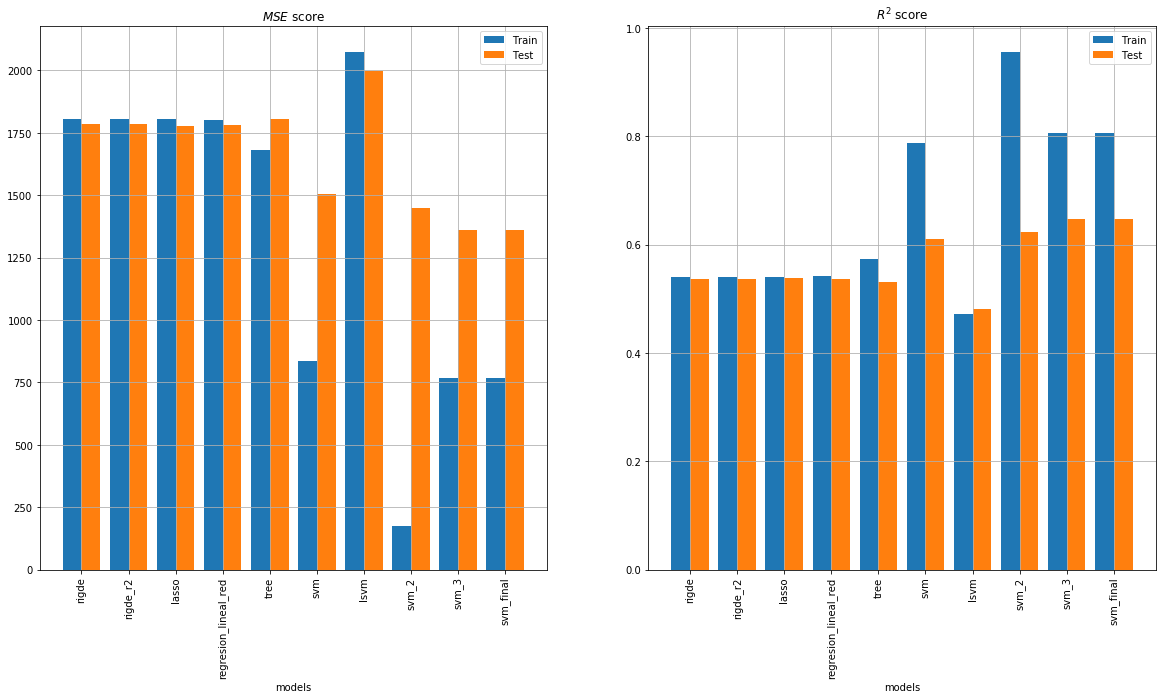

In [ ]:
models = list(resultados.keys())
models.remove('regresion_lineal')
mse_train = [ np.abs(resultados[model]['mse_train']) for model in models]
mse_test = [ np.abs(resultados[model]['mse_test']) for model in models]
r2_train = [ np.abs(resultados[model]['r2_train']) for model in models]
r2_test = [ np.abs(resultados[model]['r2_test']) for model in models]
ind = np.arange(len(models))
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
plt.bar(ind,mse_train,0.4, align="edge", label = "Train")
plt.bar(ind + 0.4,mse_test,0.4,  align="edge", label = "Test")
plt.xticks(ind + 0.4 ,models, rotation = 90)
plt.xlabel('models')
plt.title('$MSE$ score')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.bar(ind,r2_train,0.4, align="edge", label = "Train")
plt.bar(ind + 0.4,r2_test,0.4,  align="edge", label = "Test")
plt.xticks(ind + 0.4 ,models, rotation = 90)
plt.xlabel('models')
plt.title('$R^2$ score')
plt.legend()
plt.grid()

plt.show()

El general los resultados no son muy buenos con los datos que tenemos. Probablemente tendríamos que añadir más variables relacionadas con las fotos y las descripciones de los pisos.
El algoritmo que mejores prestaciones nos da es, en principio, SVM, pero tiene dos problemas. El primero es el sobreajuste y el segundo que las predicciones son muy lentas.
Yo me decantaría por la regresión lineal reducida.


In [ ]:
lr_red = LinearRegression().fit(Xs_train_red, y_train)

In [ ]:
from sklearn.externals import joblib
joblib.dump(lr_red, getOutputPath() + 'lr_red.joblib') 

['lr_red.joblib']